# **Predicting Mortality Rate of lung cancer patients in the US.**

### **Tanmay Jain**



## **Step 0: Loading the libraries and the data**


In this project, we want to develop a statistical model for the mortality rate of lung cancer in the United States.

One of the parts overlooked in many machine learning projects is preprocessing. And a good way to learn it is by solving a lot of examples and test cases. A big part of this project is walking you through preprocessing, making informed decisions using your observations, and exploratory data analysis. Then we use supervised learning methods to construct models to predict the mortality rate of lung cancer using the features provided here.

In [1]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical learning
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import tree


## Loading data
Load the three csv files as pandas dataframes directly from their URLs.

In [2]:
fulldf = pd.read_csv('https://saref.github.io/teaching/BAIT509/mydata.csv').drop(columns='Unnamed: 0')
data_dict = pd.read_csv('https://saref.github.io/teaching/BAIT509/descriptions.csv')
populationdf = pd.read_csv('https://saref.github.io/teaching/BAIT509/populations.csv').drop(columns='Unnamed: 0')

In [3]:
len(fulldf)

3134

In [4]:
fulldf.head()

State                            AreaName  All_Poverty  M_Poverty  \
0    AK      Aleutians East Borough, Alaska          553        334   
1    AK  Aleutians West Census Area, Alaska          499        273   
2    AK      Anchorage Municipality, Alaska        23914      10698   
3    AK          Bethel Census Area, Alaska         4364       2199   
4    AK         Bristol Bay Borough, Alaska           69         33   

   F_Poverty  FIPS  Med_Income  Med_Income_White  Med_Income_Black  \
0        219  2013     61518.0           72639.0           31250.0   
1        226  2016     84306.0           97321.0           93750.0   
2      13216  2020     78326.0           87235.0           50535.0   
3       2165  2050     51012.0           92647.0           73661.0   
4         36  2060     79750.0           88000.0               NaN   

   Med_Income_Nat_Am  ...  M_Without  F_With  F_Without  All_With  \
0            54750.0  ...       1317     566        540      1442   
1            48750.0  ...        769    1707        564      4177   
2            53935.0  ...      23245  122426      21393    243173   
3            41594.0  ...       2708    6627       1774     13023   
4            63333.0  ...        124     349         67       768   

   All_Without  Incidence_Rate  Avg_Ann_Incidence  Recent_Trend  \
0         1857               *         3 or fewer             *   
1         1333               *         3 or fewer             *   
2        44638            61.5                131        stable   
3         4482            62.7                  6        stable   
4          191               *         3 or fewer             *   

  Mortality_Rate Avg_Ann_Deaths  
0              *              *  
1              *              *  
2           47.3             96  
3           58.3              5  
4              *              *  

[5 rows x 23 columns]

In [5]:
populationdf.head()

POPESTIMATE2015  STATE  COUNTY
0          4858979      1       0
1            55347      1       1
2           203709      1       3
3            26489      1       5
4            22583      1       7

In [6]:
data_dict

Unnamed: 0              Feature  \
0            0                State   
1            1             AreaName   
2            2          All_Poverty   
3            3            M_Poverty   
4            4            F_Poverty   
5            5                 FIPS   
6            6           Med_Income   
7            7     Med_Income_White   
8            8     Med_Income_Black   
9            9    Med_Income_Nat_Am   
10          10     Med_Income_Asian   
11          11  Med_Income_Hispanic   
12          12               M_With   
13          13            M_Without   
14          14               F_With   
15          15            F_Without   
16          16             All_With   
17          17          All_Without   
18          18       Incidence_Rate   
19          19    Avg_Ann_Incidence   
20          20         Recent_Trend   
21          21       Mortality_Rate   
22          22       Avg_Ann_Deaths   

                                           Definition  \
0                                                 NaN   
1                                                 NaN   
2   Both male and female reported below poverty li...   
3                           Males below poverty (Raw)   
4                         Females below poverty (Raw)   
5                           State + County FIPS (Raw)   
6                   Med_Income all enthnicities (Raw)   
7                              Med_Income white (Raw)   
8                              Med_Income black (Raw)   
9                    Med_Income native American (Raw)   
10                             Med_Income Asian (Raw)   
11                          Med_Income Hispanic (Raw)   
12                  Males with health insurance (Raw)   
13               Males without health insurance (Raw)   
14                Females with health insurance (Raw)   
15             Females without health insurance (Raw)   
16            Males and Femaes with health ins. (Raw)   
17          Males an Females without health ins (Raw)   
18           Lung cancer incidence rate (per 100,000)   
19           Average lung cancer incidence rate (Raw)   
20                           Recent trend (incidence)   
21           Lung cancer mortality rate (per 100,000)   
22              Average lung cancer mortalities (Raw)   

                                 Notes  
0                                  NaN  
1                                  NaN  
2                                  NaN  
3                                  NaN  
4                                  NaN  
5                                  NaN  
6                                  NaN  
7                                  NaN  
8                                  NaN  
9                                  NaN  
10                                 NaN  
11                                 NaN  
12                                 NaN  
13                                 NaN  
14                                 NaN  
15                                 NaN  
16                                 NaN  
17                                 NaN  
18  '*' = fewer that 16 reported cases  
19                                 NaN  
20                                 NaN  
21  '*' = fewer that 16 reported cases  
22                                 NaN

Data set `mydata.csv` includes most of the data. Explanations on the meaning of each of the columns are included in `descriptions.csv`. Please take your time to understand the three dataframes before proceeding.

## **Step 1: Getting started**

## Data cleaning
In this project, we go through specific data cleaning steps. Please read through the instructions carefully.


### 1.1 Convert `FIPS` column to correct format
Federal Information Processing Standard or [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) is a categorical variable. It is a code with five digits. The left two digits showing the state and the three right digits showing the county code. We recognize that desipite being a number, FIPS is actually a categorical variable.
First, check the format of the `FIPS` column and convert them to the five digit format with type `np.object_` as seen in the county level section, [here](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=county%2Dlevel%20%20%20%20%20%20place). 

*Hint*: You can use [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to first convert the type and then use [`str.pad`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.pad.html) to format the values as five digit numbers.

In [7]:
fulldf.head()

type(fulldf['FIPS'][0])

# Converting 4-digit code to a 5-digit code by adding a zero in the beginning
fulldf['FIPS'] = fulldf['FIPS'].apply(str).str.pad(width=5, side='left', fillchar='0')
type(fulldf['FIPS'])

fulldf.info()
fulldf.head()
type(fulldf['FIPS'][0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                3134 non-null   object 
 1   AreaName             3134 non-null   object 
 2   All_Poverty          3134 non-null   int64  
 3   M_Poverty            3134 non-null   int64  
 4   F_Poverty            3134 non-null   int64  
 5   FIPS                 3134 non-null   object 
 6   Med_Income           3133 non-null   float64
 7   Med_Income_White     3132 non-null   float64
 8   Med_Income_Black     1924 non-null   float64
 9   Med_Income_Nat_Am    1474 non-null   float64
 10  Med_Income_Asian     1377 non-null   float64
 11  Med_Income_Hispanic  2453 non-null   float64
 12  M_With               3134 non-null   int64  
 13  M_Without            3134 non-null   int64  
 14  F_With               3134 non-null   int64  
 15  F_Without            3134 non-null   i

str

### 1.2 Check for null values

Just check for null values and remove columns whenever the percentage of null values is greater than 20. Please briefly justify your choices w.r.t. the columns you have removed.

In [8]:
null_percentage = fulldf.isnull().sum()/len(fulldf) 
print(null_percentage)
null_free_fulldf = fulldf.loc[:, null_percentage < .20]
print(null_free_fulldf.head())

State                  0.000000
AreaName               0.000000
All_Poverty            0.000000
M_Poverty              0.000000
F_Poverty              0.000000
FIPS                   0.000000
Med_Income             0.000319
Med_Income_White       0.000638
Med_Income_Black       0.386088
Med_Income_Nat_Am      0.529675
Med_Income_Asian       0.560625
Med_Income_Hispanic    0.217294
M_With                 0.000000
M_Without              0.000000
F_With                 0.000000
F_Without              0.000000
All_With               0.000000
All_Without            0.000000
Incidence_Rate         0.000000
Avg_Ann_Incidence      0.000000
Recent_Trend           0.000000
Mortality_Rate         0.000000
Avg_Ann_Deaths         0.000000
dtype: float64
  State                            AreaName  All_Poverty  M_Poverty  \
0    AK      Aleutians East Borough, Alaska          553        334   
1    AK  Aleutians West Census Area, Alaska          499        273   
2    AK      Anchorage Municipality,

* The columns listed below have null values for over 20% of their rows:*

1. Med_Income_Black (39%)
2. Med_Income_Nat_Am (53%)
3. Med_Income_Asian (56%)
4. Med_Income_Hispanic (22%)

These columns have been removed for the following reasons:

We believe that it would be challenging to fill these missing values using current data without introducing bias. <br>
Additionally, the focus of our prediction is the overall mortality rate rather than the mortality rate by race. As such, we have determined that the income of individuals by race is not a crucial explanatory variable.

### 1.3 Check the format of columns
Report the format of each column. List the columns that are in an unexpected format and state why you think that is the case.

*Hint*: You can do this by either inspecting the dataframe or by writing a code snippet that tells you what cells cannot be reformatted to the correct format. The Titatinc Jupyter file that we covered in class may also give you some useful ideas.

In [9]:
null_free_fulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              3134 non-null   object 
 1   AreaName           3134 non-null   object 
 2   All_Poverty        3134 non-null   int64  
 3   M_Poverty          3134 non-null   int64  
 4   F_Poverty          3134 non-null   int64  
 5   FIPS               3134 non-null   object 
 6   Med_Income         3133 non-null   float64
 7   Med_Income_White   3132 non-null   float64
 8   M_With             3134 non-null   int64  
 9   M_Without          3134 non-null   int64  
 10  F_With             3134 non-null   int64  
 11  F_Without          3134 non-null   int64  
 12  All_With           3134 non-null   int64  
 13  All_Without        3134 non-null   int64  
 14  Incidence_Rate     3134 non-null   object 
 15  Avg_Ann_Incidence  3134 non-null   object 
 16  Recent_Trend       3134 

In [10]:
import pprint
def unique_values_in_col(col):
    unique_values = col.unique()
    value_counts = col.value_counts()
    non_numeric_values = []
    for value in unique_values:
        try:
            float(value)
        except ValueError:
            non_numeric_values.append(value)
    return value_counts[value_counts.index.isin(non_numeric_values)]

unexpected_type_cols = ["Incidence_Rate","Avg_Ann_Incidence", "Mortality_Rate", "Avg_Ann_Deaths"]
non_numeric_values = null_free_fulldf[unexpected_type_cols].apply(unique_values_in_col)
pd.set_option('display.max_rows', non_numeric_values.shape[0]+1)
print(non_numeric_values)

#Reference : https://stackoverflow.com/questions/74086617/how-to-filter-pandas-unique-result-by-only-non-numeric-values
#https://stackoverflow.com/questions/30876193/is-there-a-concise-way-to-show-all-rows-in-pandas-for-just-the-current-command

            Incidence_Rate  Avg_Ann_Incidence  Mortality_Rate  Avg_Ann_Deaths
*                    211.0                NaN           325.0           325.0
1,097                  NaN                NaN             NaN             1.0
1,136                  NaN                NaN             NaN             1.0
1,243                  NaN                NaN             NaN             1.0
1,463                  NaN                NaN             NaN             1.0
104.9 #                1.0                NaN             NaN             NaN
2,369                  NaN                NaN             NaN             1.0
2,876                  NaN                NaN             NaN             1.0
3 or fewer             NaN              211.0             NaN             NaN
35.7 #                 1.0                NaN             NaN             NaN
36.6 #                 1.0                NaN             NaN             NaN
39.3 #                 1.0                NaN             NaN   

The columns **Incidence_Rate, Avg_Ann_Incidence, Mortality_Rate, and Avg_Ann_Deaths** should ideally be numerical but are currently stored as objects. This is due to the presence of special characters like <b> " * ", " _ ", " __ ", " # ", and " , " </b>, as well as non-numeric strings such as "3 or lower" in some of the rows. Before we can reformat these columns to numerical values, we need to handle the non-numeric values.

### 1.4 Merge the population data to the main dataframe
You already know about FIPS. You can use the state and county columns in this dataset to construct a FIPS column in the population dataframe in the same format as the main dataframe. Then merge the population data to the main dataframe. It is up to you to decide the type of merge and whether it is done properly.

In [11]:
print(populationdf.head(), type(populationdf['STATE'][0]))

   POPESTIMATE2015  STATE  COUNTY
0          4858979      1       0
1            55347      1       1
2           203709      1       3
3            26489      1       5
4            22583      1       7 <class 'numpy.int64'>


In [12]:
populationdf['STATE']=populationdf['STATE'].apply(str).str.pad(width=2, side='left', fillchar='0')
populationdf['COUNTY']=populationdf['COUNTY'].apply(str).str.pad(width=3, side='left', fillchar='0')

In [13]:
populationdf.head()

POPESTIMATE2015 STATE COUNTY
0          4858979    01    000
1            55347    01    001
2           203709    01    003
3            26489    01    005
4            22583    01    007

In [14]:
populationdf['FIPS']=populationdf['STATE']+populationdf['COUNTY']
populationdf.head()

POPESTIMATE2015 STATE COUNTY   FIPS
0          4858979    01    000  01000
1            55347    01    001  01001
2           203709    01    003  01003
3            26489    01    005  01005
4            22583    01    007  01007

In [15]:
fulldf_new = null_free_fulldf.merge(populationdf[['POPESTIMATE2015','FIPS']], on='FIPS', how='inner')
len(fulldf_new)

3134

The inner join method was used to merge the population estimate and FIPS dataframes. This method of merging returns the rows that have matching values in both dataframes. By using the inner join method, we are confident that the merged data will not contain any missing information, as only the rows with corresponding entries in both dataframes are included. In our case, we see that the inner join method successfully produced results for all 3,134 rows, providing a complete and accurate representation of the data.

### 1.5 Cleaning the output (response) column `Mortality_Rate`
Using the file `descriptions.csv`, explain what the non-numerical values of `Mortality_Rate` mean. 

Then, it is decision making time, we have to decide whether to remove the non-numerical values from `Mortality_Rate` or to assign a specific numerical value to them. This decision is based on you inferring if the non-numerical values were caused by error in data gathering or not. 

Note that if the observations are valid and are deleted, we are adding a bias to the model.

*Hint*: To get the full mark for this part, conduct multiple relevant exploratory data analyses. Then use them to support your decision on removing or modifying the non-numerical values. Your choice results in full mark if the supporting analysis and arguments are deemed adequate and convincing.

The non numberical value in Mortality_Rate column is '*' which means fewer than 16 reported cases. <br>
The available lowest value for Mortality_Rate is 9.2. To get the most appropriate value for estimating values for *, we have taken the average of 9.2 (min) and 16(max for *) which is 12.6. 
Hence we have replaced * with 12.6 as the most appropriate estimate.

In [16]:
fulldf_new['Mortality_Rate'] = fulldf_new['Mortality_Rate'].str.replace("*", '12.6')

<ipython-input-16-d7b8877f4d3d>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fulldf_new['Mortality_Rate'] = fulldf_new['Mortality_Rate'].str.replace("*", '12.6')


In [17]:
fulldf_new['Mortality_Rate'] = fulldf_new['Mortality_Rate'].astype(float)

In [18]:
print(fulldf_new['Mortality_Rate'].unique())

[ 12.6  47.3  58.3  54.   34.4  50.1  70.8  76.2  53.9  96.1 124.9  39.6
  60.8  59.3  48.   61.3  67.8  59.9  29.7  52.6  63.1  66.   43.   43.9
  69.1  59.7  55.1  61.2  60.2  68.9  71.9  61.4  63.6  65.3  56.3  66.1
  67.   67.7  65.8  71.2  34.5  57.8  56.1  64.   51.5  72.2  56.8  70.
  57.1  55.9  44.   41.1  50.4  51.9  51.7  66.6  63.3  52.9  49.9  60.5
  60.3  57.5  47.2  58.5  65.   51.   61.   54.5  54.4  79.8  61.7  69.9
  58.6  64.3  47.   62.6  68.3  70.2  47.7  53.3  80.1  70.5  49.2  61.8
  75.7  74.   62.8  66.9  70.1  51.3  62.5  69.6  55.6  75.3  83.1  48.4
  83.5  67.3  67.9  76.8  82.3  61.9  59.   56.6  70.4  72.3  72.5  73.1
  70.9  76.1  64.9  55.8  78.5  90.8  63.5 103.5  71.7  54.7  52.   65.9
  62.1  60.4  58.2  71.6  52.7  76.   17.7  37.   25.6  43.8  33.8  41.8
  37.7  37.2  59.1  31.   37.3  33.6  23.1  38.1  30.9  33.4  46.   40.2
  48.9  36.1  34.3  36.2  42.7  27.   36.5  41.4  56.   31.1  43.3  42.1
  34.8  31.7  40.6  31.4  32.6  37.1  42.6  29.9  39

The non-numerical value in the Mortality Rate column is represented by an asterisk (*), which indicates fewer than 16 reported cases. To derive an appropriate estimate for this missing data, we have used the minimum available value for Mortality Rate (9.2) and the maximum possible value for the * (16) to calculate an average estimate of 12.6. This average estimate is deemed the most appropriate and is used to replace the asterisks in the data set.

### 1.6 Reformat the rest of the columns (specified in 1.3) to numerical
In each column reformat all the cells that you can. 

*Hint*: You can keep the cells that you cannot reformat until you decide if you want to use the specific column in the model. This is because you want to lose as least data as possible. So you can drop the associated rows if you want to use the column and keep them if the specific column is not used.

In [19]:
#Reformating Incidence_Rate column

fulldf_new['Incidence_Rate'] = fulldf_new['Incidence_Rate'].str.replace("*", '14.75')
fulldf_new['Incidence_Rate'] = fulldf_new['Incidence_Rate'].str.replace('#', '')


<ipython-input-19-d0910c4250a5>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fulldf_new['Incidence_Rate'] = fulldf_new['Incidence_Rate'].str.replace("*", '14.75')


The non-numerical value in the Incidence_rate column is represented by an asterisk (*), which indicates fewer than 16 reported cases. To derive an appropriate estimate for this missing data, we have used the minimum available value for Incidence Rate (13.5) and the maximum possible value for the * (16) to calculate an average estimate of 14.75. This average estimate is deemed the most appropriate and is used to replace the asterisks in the data set.

In [20]:
#Replacing _, __ with mean values

fulldf_new['Incidence_Rate'] = fulldf_new['Incidence_Rate'].replace({"_": pd.NA, "__": pd.NA})
fulldf_new['Incidence_Rate'] = pd.to_numeric(fulldf_new['Incidence_Rate'], errors='coerce')
ir_mean = fulldf_new['Incidence_Rate'].mean(skipna=True)
fulldf_new['Incidence_Rate'].fillna(ir_mean, inplace=True)

In [21]:
fulldf_new['Incidence_Rate'] = fulldf_new['Incidence_Rate'].astype(float)

In [22]:
#Reformating Avg_Ann_Incidence non numeric values using Mean

fulldf_new['Avg_Ann_Incidence'] = fulldf_new['Avg_Ann_Incidence'].str.replace("3 or fewer", '1.5')
fulldf_new['Avg_Ann_Incidence'] = fulldf_new['Avg_Ann_Incidence'].replace({"_": pd.NA, "__": pd.NA})
fulldf_new['Avg_Ann_Incidence'] = pd.to_numeric(fulldf_new['Avg_Ann_Incidence'], errors='coerce')
aai_mean = fulldf_new['Avg_Ann_Incidence'].mean(skipna=True)
fulldf_new['Avg_Ann_Incidence'].fillna(aai_mean, inplace=True)

In [23]:
print(aai_mean)

70.97111111111111


In [24]:
##Reformating Avg_Ann_Deaths non numeric values using Mean

fulldf_new['Avg_Ann_Deaths'] = fulldf_new['Avg_Ann_Deaths'].replace({"_": pd.NA, "__": pd.NA})
fulldf_new['Avg_Ann_Deaths'] = pd.to_numeric(fulldf_new['Avg_Ann_Deaths'], errors='coerce')
aad_mean = fulldf_new['Avg_Ann_Deaths'].mean(skipna=True)
fulldf_new['Avg_Ann_Deaths'].fillna(aad_mean, inplace=True)

In [25]:
#Reformating Recent_Trend
fulldf_new.replace(['*','_','__'],'stable', inplace=True)

fulldf_new['Recent_Trend'] = fulldf_new['Recent_Trend'].str.replace('stable','1')
fulldf_new['Recent_Trend'] = fulldf_new['Recent_Trend'].str.replace('falling','2')
fulldf_new['Recent_Trend'] = fulldf_new['Recent_Trend'].str.replace('rising','3')

fulldf_new['Recent_Trend'] = fulldf_new['Recent_Trend'].astype(float)
#https://stackoverflow.com/questions/46920454/how-to-replace-multiple-values-with-one-value-python

In [26]:
print(fulldf_new['Recent_Trend'].unique())

[1. 2. 3.]


In [27]:
#replaced a null value in Med_Income column with an estimate value 
fulldf_new['Med_Income'] = fulldf_new['Med_Income'].fillna(100)


In [28]:
fulldf_new.head()

State                            AreaName  All_Poverty  M_Poverty  \
0    AK      Aleutians East Borough, Alaska          553        334   
1    AK  Aleutians West Census Area, Alaska          499        273   
2    AK      Anchorage Municipality, Alaska        23914      10698   
3    AK          Bethel Census Area, Alaska         4364       2199   
4    AK         Bristol Bay Borough, Alaska           69         33   

   F_Poverty   FIPS  Med_Income  Med_Income_White  M_With  M_Without  F_With  \
0        219  02013     61518.0           72639.0     876       1317     566   
1        226  02016     84306.0           97321.0    2470        769    1707   
2      13216  02020     78326.0           87235.0  120747      23245  122426   
3       2165  02050     51012.0           92647.0    6396       2708    6627   
4         36  02060     79750.0           88000.0     419        124     349   

   F_Without  All_With  All_Without  Incidence_Rate  Avg_Ann_Incidence  \
0        540      1442         1857           14.75                1.5   
1        564      4177         1333           14.75                1.5   
2      21393    243173        44638           61.50              131.0   
3       1774     13023         4482           62.70                6.0   
4         67       768          191           14.75                1.5   

   Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  POPESTIMATE2015  
0           1.0            12.6       52.308598             3341  
1           1.0            12.6       52.308598             5702  
2           1.0            47.3       96.000000           298695  
3           1.0            58.3        5.000000            17946  
4           1.0            12.6       52.308598              892

In [29]:
len(fulldf_new)

3134

### 1.7 Make the numerical data useful
We know we have many columns of data, some of them are dependent on the populations. As a *Hint*, convert all the raw data to per 100,000 persons rates (divide by population and multiply by 100,000).

In [30]:
columns_to_normalize = ['All_Poverty','M_Poverty','F_Poverty','Med_Income','Med_Income_White','M_With','M_Without','F_With','F_Without','All_With','All_Without','Avg_Ann_Incidence','Avg_Ann_Deaths'
]

# Dividing each column by POPESTIMATE2015 and multiply by 100,000
for column in columns_to_normalize:
    fulldf_new[column] = fulldf_new[column].div(fulldf_new['POPESTIMATE2015'], axis=0) * 100000


In [31]:
round(fulldf_new.head(),2)

State                            AreaName  All_Poverty  M_Poverty  \
0    AK      Aleutians East Borough, Alaska     16551.93    9997.01   
1    AK  Aleutians West Census Area, Alaska      8751.32    4787.79   
2    AK      Anchorage Municipality, Alaska      8006.16    3581.58   
3    AK          Bethel Census Area, Alaska     24317.40   12253.43   
4    AK         Bristol Bay Borough, Alaska      7735.43    3699.55   

   F_Poverty   FIPS  Med_Income  Med_Income_White    M_With  M_Without  \
0    6554.92  02013  1841305.00        2174169.41  26219.69   39419.34   
1    3963.52  02016  1478533.85        1706787.09  43318.13   13486.50   
2    4424.58  02020    26222.74          29205.38  40424.85    7782.19   
3   12063.97  02050   284252.76         516254.32  35640.25   15089.71   
4    4035.87  02060  8940582.96        9865470.85  46973.09   13901.35   

     F_With  F_Without  All_With  All_Without  Incidence_Rate  \
0  16941.04   16162.83  43160.73     55582.16           14.75   
1  29936.86    9891.27  73255.00     23377.76           14.75   
2  40986.96    7162.16  81411.81     14944.34           61.50   
3  36927.45    9885.21  72567.70     24974.92           62.70   
4  39125.56    7511.21  86098.65     21412.56           14.75   

   Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  \
0              44.90           1.0            12.6         1565.66   
1              26.31           1.0            12.6          917.37   
2              43.86           1.0            47.3           32.14   
3              33.43           1.0            58.3           27.86   
4             168.16           1.0            12.6         5864.19   

   POPESTIMATE2015  
0             3341  
1             5702  
2           298695  
3            17946  
4              892

## **Step 2: Exploratory analysis**

### 2.1 Visualizing different features
Here, show different feature and how they change with respect to each other.
*Hint*: A good function to use here is `sns.pairplot`. Remember to have the plots labeled properly so that they are self explanatory.


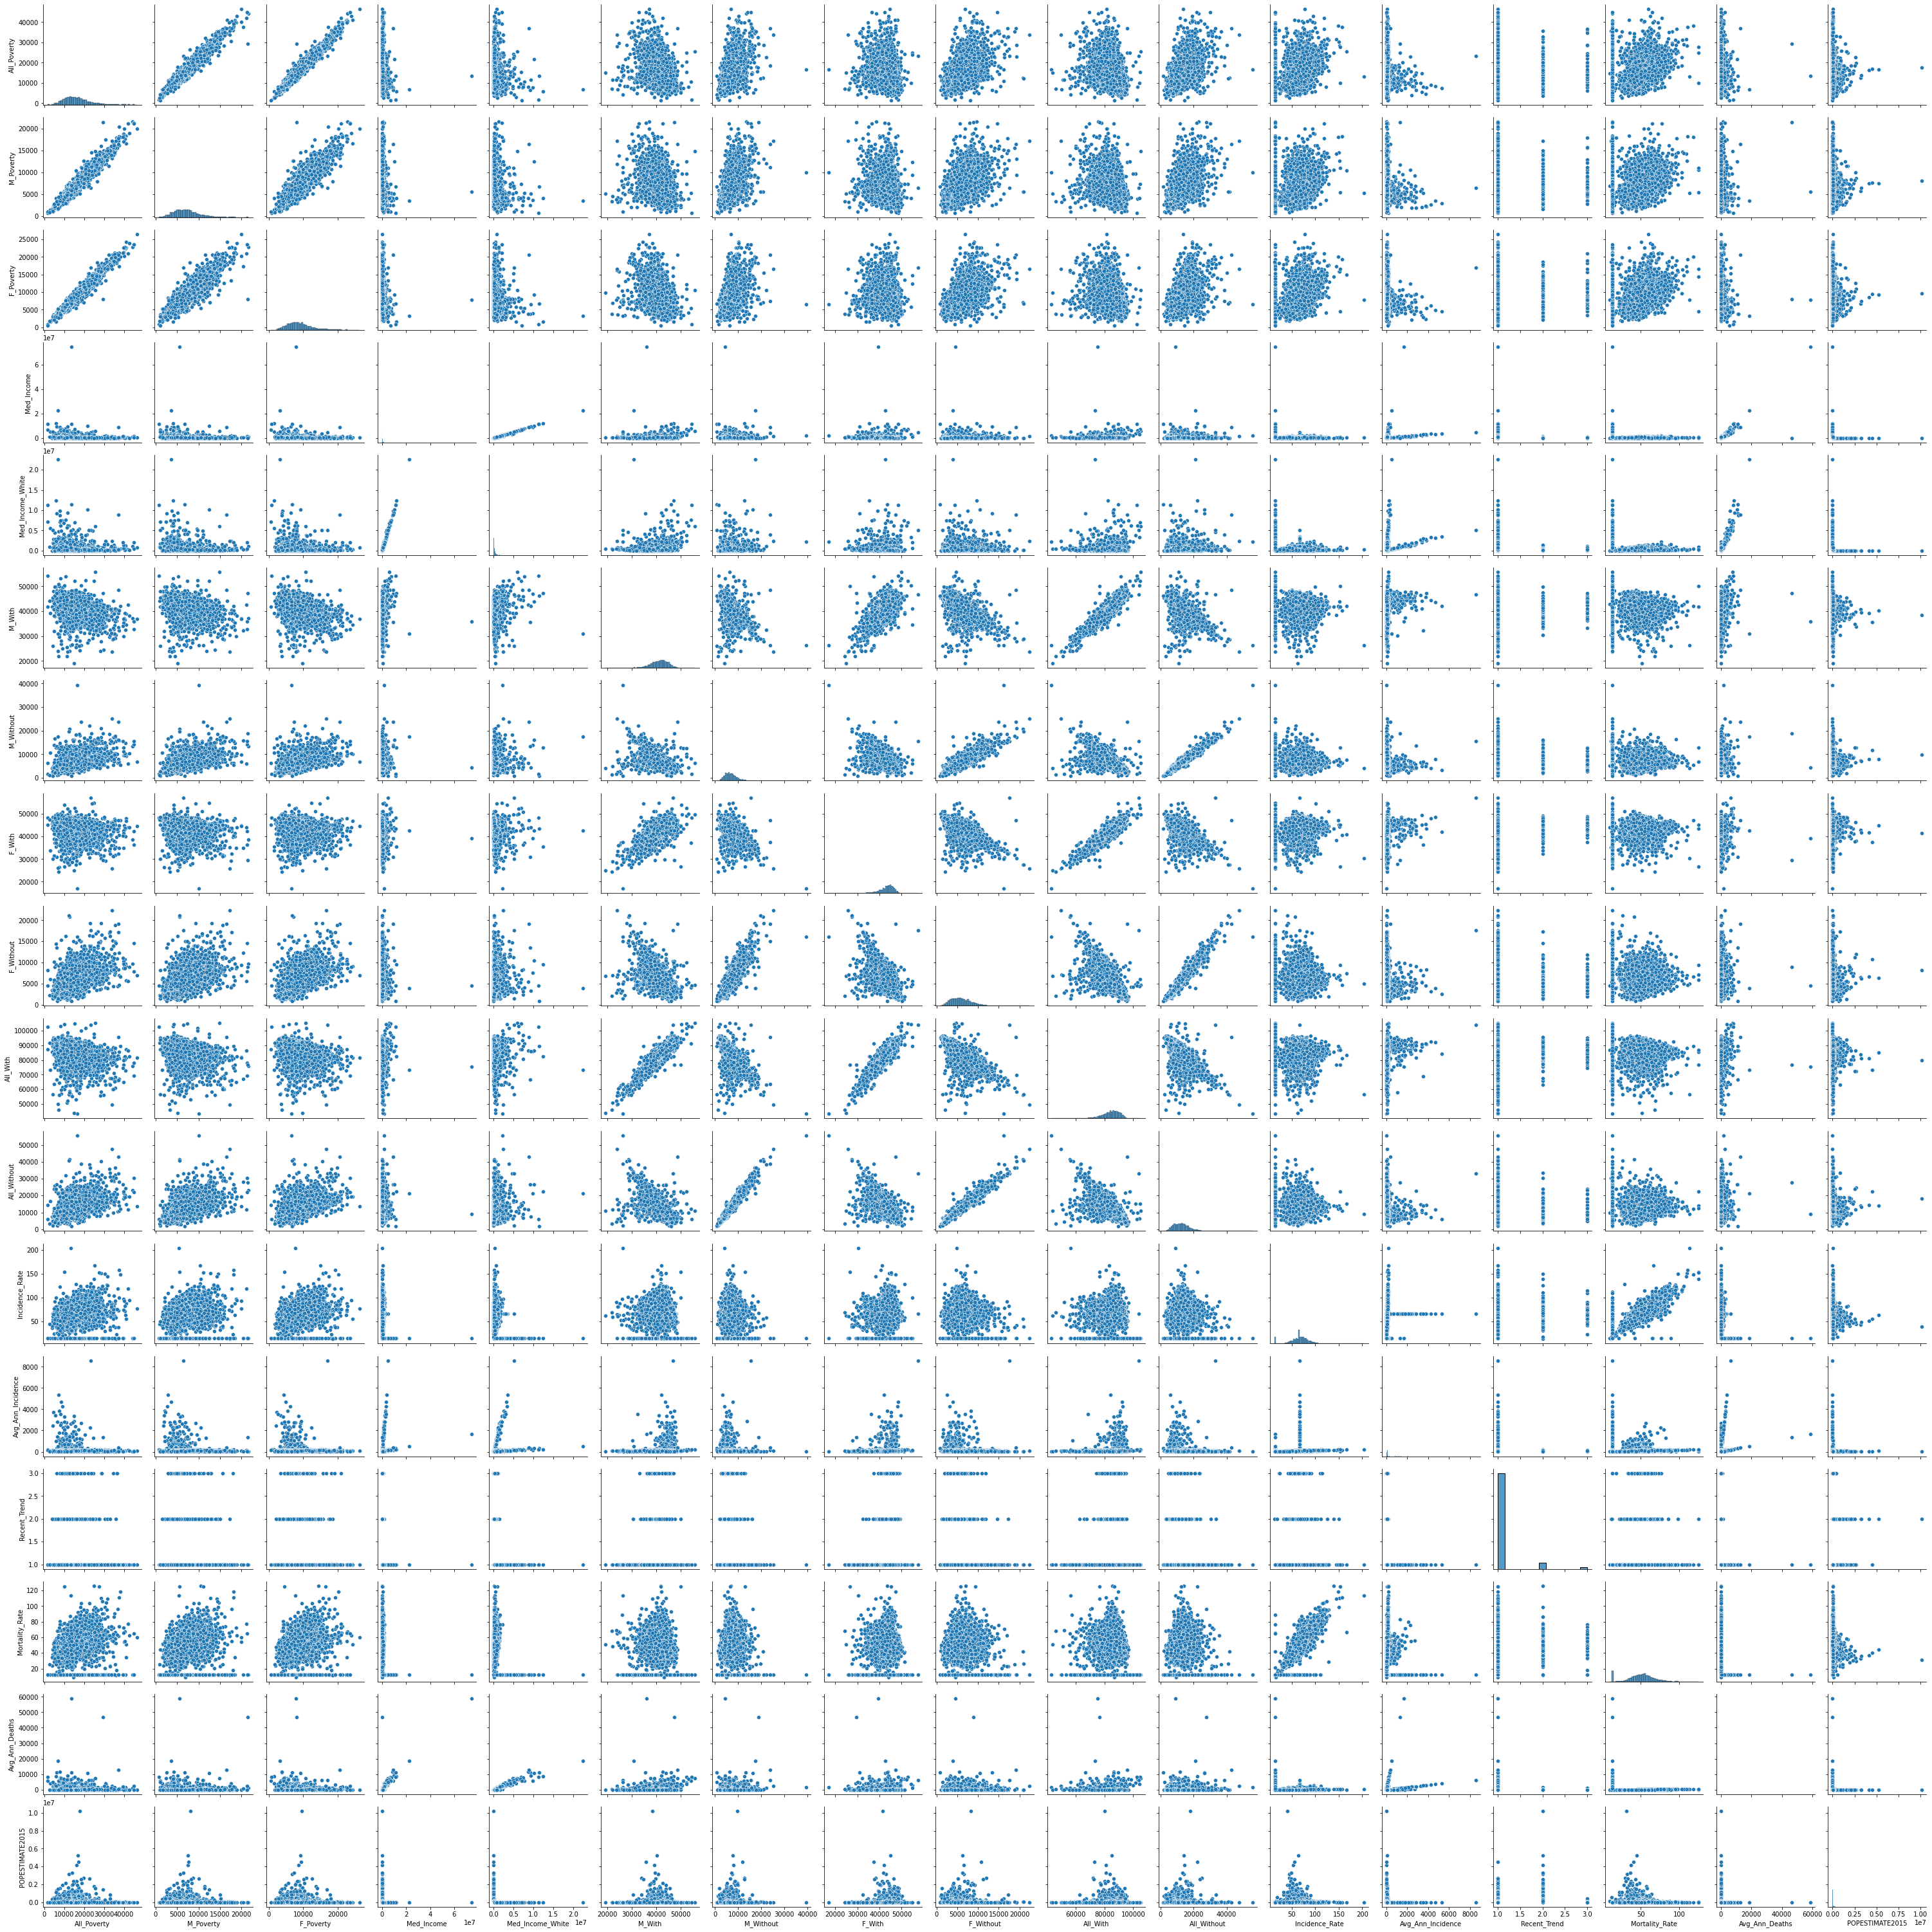

In [101]:
sns.pairplot(fulldf_new)

In [33]:
#calculating correlation matrix
corr = fulldf_new.corr()

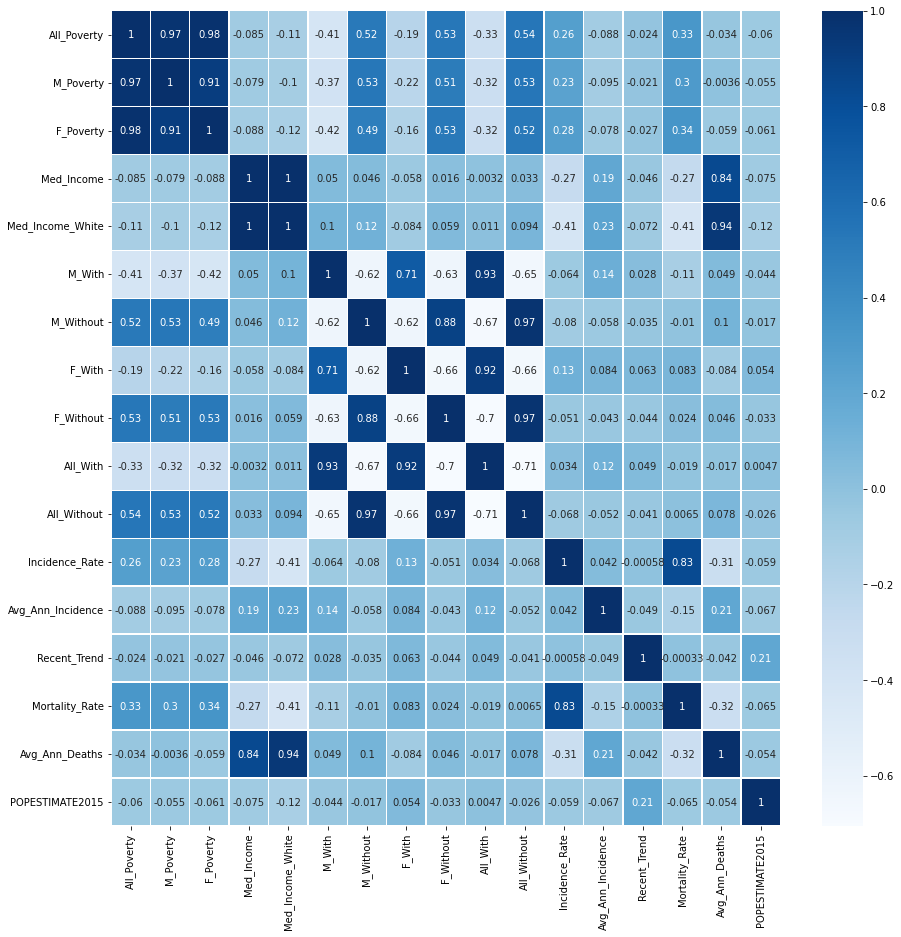

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the correlation heatmap
sns.heatmap(corr, 
            annot=True, 
            cmap="Blues", 
            linewidths=0.5)

# Show the plot
plt.show()
# https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps

### 2.2 Selecting the most important features
In this step, we want to remove the redundant features. 

*Hint*: This can be done by analyzing the correlation between the features and removing the highly correlated features. Remember, throughout the project, write down specific reasons for any desicion you make.

##### Features selected: 
All_Poverty, All_With, All_Without, Med_Income, Incidence_rate, Avg_Ann_Incidence, Recent_Trend, Mortality_Rate and Avg_Ann_Deaths


There is a high correlation between the total poverty, with and without insurance features and their gender-based breakdown. <br> 
For the purposes of forecasting mortality rate we have disregarded variables such as "M_Poverty," "F_Poverty," "M_With," "M_Without," "F_With," and "F_Without." <br>
Instead, we have considered only "All_Poverty," "All_With," and "All_Without." <br>
We have found a high correlation between Med_Income and Med_Income_White and we have decided to drop Med_Income_White from the data.<br>
<br>
This decision was made as our goal is to predict overall mortality rate, rather than predicting it for individual genders or race.<br>

We have also not considered State, County name (AreaName) and FIPS columns for our predictive model.

In [35]:
model_df = fulldf_new.drop(["M_Poverty","F_Poverty", "M_With", "M_Without", "F_With", 
                            "F_Without", "Med_Income_White", "State", "AreaName", "FIPS", "POPESTIMATE2015"], axis=1)
round(model_df.head(),2)

All_Poverty  Med_Income  All_With  All_Without  Incidence_Rate  \
0     16551.93  1841305.00  43160.73     55582.16           14.75   
1      8751.32  1478533.85  73255.00     23377.76           14.75   
2      8006.16    26222.74  81411.81     14944.34           61.50   
3     24317.40   284252.76  72567.70     24974.92           62.70   
4      7735.43  8940582.96  86098.65     21412.56           14.75   

   Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0              44.90           1.0            12.6         1565.66  
1              26.31           1.0            12.6          917.37  
2              43.86           1.0            47.3           32.14  
3              33.43           1.0            58.3           27.86  
4             168.16           1.0            12.6         5864.19

## **Step 3: Regression Model Construction**

### 3.1 Splitting the dataset

Split the dataset to three parts: train, validation, and test. You choose the ratios for the three datasets and provide a one-sentence rationale on why you went with such ratios.

*Hint*: You can use the validation set approach from ch5 lab (google colab).

In [36]:
# Shuffle the dataset and reset the index
# We are going to do a 3-way split of the data to 50%, 25%, 25% 
# for training, validation, and test datasets respectively
model_df = model_df.sample(frac=1).reset_index(drop=True)
round(model_df.head(),2)

All_Poverty  Med_Income   All_With  All_Without  Incidence_Rate  \
0     14361.23   218267.34   93585.38      5688.94           79.10   
1     18712.20    26527.79   89206.73      7687.30           44.90   
2     16790.05     1054.77   84985.82     14143.29           63.40   
3     10021.47  3233357.19  104438.08      6370.79           14.75   
4     14980.88    57791.92   89993.22      6454.50           77.00   

   Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0              98.55           1.0            66.6           85.11  
1              54.47           1.0            33.3           40.22  
2              64.12           2.0            44.7            1.00  
3             107.37           1.0            12.6         3744.35  
4             101.07           1.0            56.2           75.80

In [37]:
len(model_df)

3134

In [38]:
# Separate the last 25% as hold-out data (test data)
model_df_hold_out=model_df[int(0.75*len(model_df)):len(model_df)]
model_df_hold_out

All_Poverty    Med_Income      All_With   All_Without  Incidence_Rate  \
2350  12644.215778  7.110851e+05  90427.190521   9183.037106           51.10   
2351  12469.884893  1.187494e+05  88971.178728  10033.907379           52.30   
2352   8882.039787  1.768703e+06  77388.624264  18940.879798           14.75   
2353  15988.680580  6.724764e+04  87567.932598  12097.629996           59.30   
2354  28221.005001  3.683377e+05  68718.742558  29733.269826           59.40   
...            ...           ...           ...           ...             ...   
3129  19674.844164  9.310200e+03  83430.908564  13903.727423           57.40   
3130  17402.665273  1.081944e+06  79801.411027  20381.499869           46.70   
3131  14602.637809  3.186879e+05  87040.919851  13067.297937           92.00   
3132  22773.804515  5.061983e+05  82232.505960  15495.722900          106.50   
3133  26112.045167  7.603421e+04  88652.261453   7870.975777           41.70   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
2350          93.545370           1.0            39.7       62.363580  
2351          91.460694           1.0            40.2       69.153208  
2352          42.028579           1.0            12.6     1465.637375  
2353          86.825096           2.0            55.1       80.393607  
2354          59.537985           1.0            75.8       71.445582  
...                 ...           ...             ...             ...  
3129          50.706925           1.0            42.1       37.147930  
3130          78.390384           1.0            46.9       78.390384  
3131         142.035847           1.0            62.3      101.454177  
3132         140.232786           1.0            89.6      112.186229  
3133          31.135189           1.0            31.7       22.832472  

[784 rows x 9 columns]

In [39]:
# Keep the first 75% as training+validation data
model_df_acc=model_df[0:int(0.75*len(model_df))]
model_df_acc

All_Poverty    Med_Income       All_With   All_Without  Incidence_Rate  \
0     14361.225587  2.182673e+05   93585.378964   5688.944634        79.10000   
1     18712.199890  2.652779e+04   89206.732238   7687.295090        44.90000   
2     16790.048368  1.054768e+03   84985.823418  14143.288478        63.40000   
3     10021.474588  3.233357e+06  104438.081603   6370.794560        14.75000   
4     14980.877675  5.779192e+04   89993.223921   6454.502647        77.00000   
...            ...           ...            ...           ...             ...   
2345  12668.463612  7.543726e+05   90266.546870   8056.304283        65.85653   
2346  16743.836440  5.974293e+04   76166.566446  11686.710764       106.80000   
2347  10465.100799  7.116517e+03   87342.566419   9445.615468        49.20000   
2348  12108.731466  6.610379e+05   67429.983526  15617.792422        89.80000   
2349  13807.746751  6.636340e+05   86205.121606  12057.650238        59.30000   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0             98.548647           1.0            66.6       85.110195  
1             54.472886           1.0            33.3       40.218299  
2             64.124885           2.0            44.7        0.998596  
3            107.372942           1.0            12.6     3744.352035  
4            101.066945           1.0            56.2       75.800209  
...                 ...           ...             ...             ...  
2345        1062.759975           1.0            38.6       74.872716  
2346         123.271197           1.0            76.7       88.695129  
2347          49.168179           2.0            36.1       35.855495  
2348         115.321252           1.0            65.0       82.372323  
2349          77.210140           1.0            42.7       64.341784  

[2350 rows x 9 columns]

In [40]:
training_data = model_df_acc.sample(frac=0.667, random_state=25)
training_data

All_Poverty     Med_Income      All_With   All_Without  Incidence_Rate  \
1237  13141.656820  257076.276749  56616.778259   9150.584220       203.70000   
1442  12113.574910    7103.823194  83983.131782  10750.230463        76.10000   
55    14046.250553   96159.243382  83533.572980  15191.941716        78.60000   
1841  13798.683057  111890.689260  90190.349911   8283.704519        45.40000   
203   15718.976536   10425.675437  88688.298246   8535.250579        65.85653   
...            ...            ...           ...           ...             ...   
283   14027.465280  340103.964621  87275.971759  12661.959811        71.10000   
1002  11593.691149  457120.998117  75435.499058  13100.282486        55.40000   
1300  17177.354252  148011.652803  87115.229371  11972.201748        75.90000   
600   14223.967827   90209.159416  86585.984628  12397.346513        61.20000   
1846  19773.119045   40723.995912  85346.669557  14638.879427        72.30000   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
1237         229.749245           1.0           113.5      124.721019  
1442          69.909023           2.0            51.6       46.921989  
55           107.648834           1.0            58.7       80.736626  
1841          47.194193           1.0            34.5       35.957480  
203           13.188396           1.0            43.0       42.182880  
...                 ...           ...             ...             ...  
283          100.861199           1.0            64.5       93.102646  
1002          94.161959           1.0            40.7       70.621469  
1300          98.276649           1.0            66.3       87.747008  
600           77.048841           1.0            53.5       65.773401  
1846          92.899390           1.0            59.2       75.351727  

[1567 rows x 9 columns]

In [41]:
validation_data = model_df_acc.drop(training_data.index)
validation_data

All_Poverty    Med_Income      All_With   All_Without  Incidence_Rate  \
0     14361.225587  2.182673e+05  93585.378964   5688.944634        79.10000   
2     16790.048368  1.054768e+03  84985.823418  14143.288478        63.40000   
4     14980.877675  5.779192e+04  89993.223921   6454.502647        77.00000   
5     16674.913409  1.100569e+06  88075.210292  10217.714003        55.40000   
10    22724.341059  1.625876e+05  87861.719052  12172.679193        71.80000   
...            ...           ...           ...           ...             ...   
2336  13112.342046  4.179072e+05  88930.240609   9788.817725        59.70000   
2339  16736.984530  3.550552e+04  83192.364347  12945.818587        73.20000   
2344  18723.404255  2.989716e+06  80780.141844  15886.524823        14.75000   
2345  12668.463612  7.543726e+05  90266.546870   8056.304283        65.85653   
2348  12108.731466  6.610379e+05  67429.983526  15617.792422        89.80000   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0             98.548647           1.0            66.6       85.110195  
2             64.124885           2.0            44.7        0.998596  
4            101.066945           1.0            56.2       75.800209  
5             98.960910           1.0            12.6     1294.126619  
10            94.595176           1.0            51.7       68.796491  
...                 ...           ...             ...             ...  
2336          77.895101           1.0            48.7       69.240090  
2339          63.985923           1.0            56.4       47.989442  
2344         106.382979           1.0            12.6     3709.829640  
2345        1062.759975           1.0            38.6       74.872716  
2348         115.321252           1.0            65.0       82.372323  

[783 rows x 9 columns]

### 3.2 Model training
Create three different models, using different features (and optionally nonlinear transformations). The purpose of these models is to predict mortality rate of lung cancer with reasonably high R2 (at least exceeding 70%) using a carefully chosen and justified set of features. Use the visualizations from section 2.1 to inform the feature selection for each model.

In [42]:
#Top model
formula1 = 'Mortality_Rate ~ (All_Poverty+Med_Income)*(Incidence_Rate+Avg_Ann_Incidence)'


In [43]:
lm1 = smf.ols(formula1, data = training_data).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     524.3
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:03:38   Log-Likelihood:                -5718.5
No. Observations:                1567   AIC:                         1.146e+04
Df Residuals:                    1558   BIC:                         1.150e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [44]:
formula2 = 'Mortality_Rate ~ (Med_Income)*(Incidence_Rate+Avg_Ann_Incidence)'

In [45]:
lm2 = smf.ols(formula2, data = training_data).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     794.7
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:03:38   Log-Likelihood:                -5750.4
No. Observations:                1567   AIC:                         1.151e+04
Df Residuals:                    1561   BIC:                         1.154e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [46]:
formula3 = 'Mortality_Rate ~ (Med_Income+All_Poverty)*(Incidence_Rate)+Avg_Ann_Incidence'

In [47]:
lm3 = smf.ols(formula3, data = training_data).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     689.4
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:03:38   Log-Likelihood:                -5727.2
No. Observations:                1567   AIC:                         1.147e+04
Df Residuals:                    1560   BIC:                         1.151e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 3.3 Model selection
Using different model selection criteria and validation dataset, choose the single best perfoming model among the three models.

In [48]:
preds1 = lm1.predict(model_df_acc)
square_error1 = (model_df_acc['Mortality_Rate'] - preds1)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error1[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 82.44606951310013


In [49]:
preds2 = lm2.predict(model_df_acc)
square_error2 = (model_df_acc['Mortality_Rate'] - preds2)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error2[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 86.45348629722946


In [50]:
preds3 = lm3.predict(model_df_acc)
square_error3 = (model_df_acc['Mortality_Rate'] - preds3)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error3[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 84.2960570144031


The best model we have selected is Model 1 . The model contains the following explanatory variables : Med_Income, All_Poverty, Incidence_Rate, and Avg_Ann_Incidence in the following manner.
'Mortality_Rate ~ (All_Poverty+Med_Income)*(Incidence_Rate+Avg_Ann_Incidence)'

The R -squared value is 0.729 The Mean Squared Error for the validation set is 82.44. After fitting this into the test set, the MSE for the test set was 72.63.We chose this model because it was really consistent . Multiple re-runs despite the random seed derived segregation of our data resulted in similar acceptable range for R-squared as well as MSE.






## **Step 4: Model diagnostics**
Explore model collinearity with `variance_inflation_factor`. Larger values of VIF indicate multicollinearity. Remove the problematic features and refit the model. Report how model R-squared is affected.

*Hint:* Consider VIF > 10 as an indicator of multicollinearity. If the VIF for all your features is below 10, it is a positive indication that the level of collinearity is acceptably low without any changes to the model needed in this step.

In [51]:
# the independent variables set

X5 = model_df_acc[['All_Poverty','Med_Income','Avg_Ann_Incidence','Incidence_Rate']] #For top model 
X7 = model_df_acc[['Med_Income','Avg_Ann_Incidence', 'Incidence_Rate']] 

#Other models
#X1 = model_df_acc[['All_Poverty','Med_Income','All_With','Incidence_Rate','Avg_Ann_Incidence','Avg_Ann_Deaths']]
#X2 = model_df_acc[['Med_Income','All_With','Incidence_Rate','Avg_Ann_Deaths']]
#X3 = model_df_acc[['Med_Income','All_With','Avg_Ann_Incidence','Avg_Ann_Deaths']]
#X4 = model_df_acc[['Med_Income','All_With','Incidence_Rate']]
#X6 = model_df_acc[['All_Poverty','Incidence_Rate','Avg_Ann_Deaths']]

X = X5
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

             feature       VIF
0        All_Poverty  6.180864
1         Med_Income  1.103291
2  Avg_Ann_Incidence  1.223168
3     Incidence_Rate  6.360050


## **Step 5: Reporting test performance**
Report the MSE of the final regression model using the test set.

#####*Here we find the test MSE of only the final chosen regression model*  

In [52]:
#For top model
preds_hold_out = lm1.predict(model_df_hold_out)
square_error_hold_out = (model_df_hold_out['Mortality_Rate'] - preds_hold_out)**2
print('--------Test MSE for linear regression model--------')
print('MSE:',np.mean(square_error_hold_out))

--------Test MSE for linear regression model--------
MSE: 72.631452616116


In [53]:
preds_hold_out = lm2.predict(model_df_hold_out)
square_error_hold_out = (model_df_hold_out['Mortality_Rate'] - preds_hold_out)**2
print('--------Test MSE for linear regression model--------')
print('MSE:',np.mean(square_error_hold_out))

--------Test MSE for linear regression model--------
MSE: 74.51786179888053


In [54]:
preds_hold_out = lm3.predict(model_df_hold_out)
square_error_hold_out = (model_df_hold_out['Mortality_Rate'] - preds_hold_out)**2
print('--------Test MSE for linear regression model--------')
print('MSE:',np.mean(square_error_hold_out))

--------Test MSE for linear regression model--------
MSE: 73.13211086452337


## **Step 6: Alternative predictive model**

Use one other supervised learning model to outperform the regression model from part 5 (in terms of MSE) on the same hold-out test set. Document, justify, and explain all your decision w.r.t. the implementation of this alternative predictive model.

This part is deliberately designed without clear instructions as bonus points for efforts of groups in completing a very common ML task without a walkthrough or instrcutions.

*Since we're predicting quantitative values, we need to use regression models for predictions and classification models won't work accurately. In addition to Simple linear (single/multivariate) regression models, we can also use tree based models when the relation between features and response variable may be complex and non-linear.*

*Therefore, we are using a regressor tree model to check if we can improve our predictions compared to our previous regression models in part part 3,4,5 based on the MSE of test set.*

*Since we've already cleaned the data in earlier parts, we shall use the same training and test sets as before.  Also, we choose the same set of features with which we got the best performance for our earlier predictive models. We will be comparing the regressor trees with two different k_folds, 5 & 10 to see which performs better among them and then compare the MSE of the better one with our final regression model from part 5.*

*Please also note that we're performing cross-validation on the training set which takes care of the validation set as well. Once we run the cross_validation on the training set, we get a set of cross validation scores for each depth level of the tree. We plot the corresponding values to decide the optimal value for the depth hyperparameter and use that to fit the regressor tree model.*

In [55]:
x = model_df_acc[['All_Poverty','Med_Income','Incidence_Rate','Avg_Ann_Incidence']]
y = model_df_acc['Mortality_Rate']

In [56]:
X_train = model_df_acc[['All_Poverty','Med_Income','Incidence_Rate','Avg_Ann_Incidence']]
X_val = model_df_hold_out[['All_Poverty','Med_Income','Incidence_Rate','Avg_Ann_Incidence']]
y_train = model_df_acc['Mortality_Rate']
y_val = model_df_hold_out['Mortality_Rate']
# X_train, X_val, y_train, y_val = train_test_split(x,y,train_size=0.75,random_state=0)
k_fold = KFold(n_splits=5)
depth = []
for i in range(2,10):
    regr_tree = DecisionTreeRegressor(max_depth=i)
    scores = cross_val_score(regr_tree, x, y, cv=k_fold, n_jobs=-1)
    depth.append((i,scores.mean()))
print(depth)

[(2, 0.5944551351536752), (3, 0.6473272866815275), (4, 0.6712865655523018), (5, 0.6765018767448446), (6, 0.6720136540746982), (7, 0.6494033204102594), (8, 0.6404133724462728), (9, 0.6227627312862112)]


Text(0.5, 1.0, 'k_fold=5')

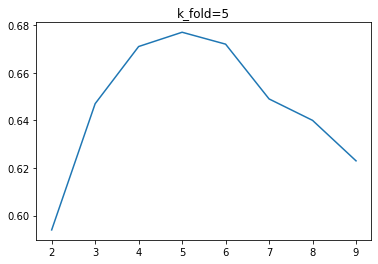

In [57]:
plot_x = []
plot_y = []
for i in range(0, len(depth)):
  plot_x.append(depth[i][0])
  plot_y.append(round(depth[i][1],3))

plt.plot(plot_x,plot_y)
plt.title("k_fold=5")

In [58]:
# X_train, X_val, y_train, y_val = train_test_split(x,y,train_size=0.75,random_state=0)
k_fold = KFold(n_splits=10)
depth = []
for i in range(2,10):
    # regr_tree.fit(X_train, y_train)
    regr_tree = DecisionTreeRegressor(max_depth=i)
    scores = cross_val_score(regr_tree, x, y, cv=k_fold, n_jobs=-1)
    depth.append((i,scores.mean()))
print(depth)

[(2, 0.5922581228185728), (3, 0.6407895146428848), (4, 0.6737656538432237), (5, 0.67193327832924), (6, 0.6626843552654549), (7, 0.6481824506721681), (8, 0.6478328199523962), (9, 0.6060564204097164)]


Text(0.5, 1.0, 'k_fold=10')

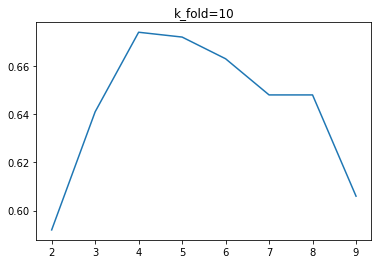

In [59]:
plot_x = []
plot_y = []
for i in range(0, len(depth)):
  plot_x.append(depth[i][0])
  plot_y.append(round(depth[i][1],3))

plt.plot(plot_x,plot_y)
plt.title("k_fold=10")

Based on the above two plots, with 5 and 10 folds respectively, we see that a depth of 4 & 5 give the best cross validation scores for the regressor tree. Hence we try to fit training set using both dpeth values, however, we see that depth=4 gives us a lower MSE among the two. 

In [60]:
regr_tree = DecisionTreeRegressor(max_depth=4)
regr_tree.fit(X_train, y_train)

regr_tree2 = DecisionTreeRegressor(max_depth=5)
regr_tree2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5)

In [61]:
y_pred = regr_tree.predict(X_val)
print(mean_squared_error(y_val, y_pred))

y_pred2 = regr_tree2.predict(X_val)
print(mean_squared_error(y_val, y_pred2))

84.85953202705427
99.49602394403132


*We see here that our this test MSE  of 84.86 using depth = 4 is higher than our earlier Test MSE of 72.6 from our chosen regression model. This can be due to overfitting in the regressor tree model which even after corss validation is not able to predict as accurately on the test data compared to our original regression model.* 

*Please note that we typically expect such complex models to perform better especially when we cross validate and choose optimal hyperparameters while fitting the data. But we see here that we're able to get a better accuracy with a simpler model.* 


Reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

### **APPENDIX 1 - Approach 2 - Filling missing values with Median Values**

In [62]:
# Merged data

fulldf_median =  null_free_fulldf.merge(populationdf[['POPESTIMATE2015','FIPS']], on='FIPS', how='inner')

In [63]:
# Cleaning data 
# Cleaning the output - Response column 
fulldf_median['Mortality_Rate'] = fulldf_median['Mortality_Rate'].str.replace("*", '8')

<ipython-input-63-ac8821859457>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fulldf_median['Mortality_Rate'] = fulldf_median['Mortality_Rate'].str.replace("*", '8')


In [64]:
fulldf_median['Mortality_Rate'] = fulldf_median['Mortality_Rate'].astype(float)

In [65]:
#Reformating Incidence_Rate column with * and #


fulldf_median['Incidence_Rate'] = fulldf_median['Incidence_Rate'].str.replace("*", '8')
fulldf_median['Incidence_Rate'] = fulldf_median['Incidence_Rate'].str.replace('#', '')

<ipython-input-65-935f7cda5002>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fulldf_median['Incidence_Rate'] = fulldf_median['Incidence_Rate'].str.replace("*", '8')


In [66]:
#Reformating Incidence_Rate column with _ and __ with median values

fulldf_median['Incidence_Rate'] = fulldf_median['Incidence_Rate'].replace({"_": pd.NA, "__": pd.NA})
ir_median = fulldf_median['Incidence_Rate'].median(skipna=True)
fulldf_median['Incidence_Rate'].fillna(ir_median, inplace=True)


In [67]:
fulldf_median['Incidence_Rate'] = fulldf_median['Incidence_Rate'].astype(float)

In [68]:
#Reformating Avg_Ann_Incidence column (median)

fulldf_median['Avg_Ann_Incidence'] = fulldf_median['Avg_Ann_Incidence'].str.replace("3 or fewer", '1.5')
fulldf_median['Avg_Ann_Incidence'] = fulldf_median['Avg_Ann_Incidence'].replace({"_": pd.NA, "__": pd.NA})
avg_ann_median = fulldf_median['Avg_Ann_Incidence'].median(skipna=True)
print(avg_ann_median)
fulldf_median['Avg_Ann_Incidence'].fillna(avg_ann_median, inplace=True)
fulldf_median['Avg_Ann_Incidence'] = fulldf_median['Avg_Ann_Incidence'].astype(float)

25.0


In [69]:
#Reformating Avg_Ann_Deaths column (median)
fulldf_median['Avg_Ann_Deaths'] = fulldf_median['Avg_Ann_Deaths'].replace({"*": pd.NA})
fulldf_median['Avg_Ann_Deaths'] = fulldf_median['Avg_Ann_Deaths'].str.replace(',', '')
avg_ann_death_median = fulldf_median['Avg_Ann_Deaths'].median(skipna=True)
print(avg_ann_death_median)
fulldf_median['Avg_Ann_Deaths'].fillna(avg_ann_death_median, inplace=True)
fulldf_median['Avg_Ann_Deaths'] = fulldf_median['Avg_Ann_Deaths'].astype(float)


21.0


In [70]:
#Reformating Recent_Trend
fulldf_median.replace(['*','_','__'],'stable', inplace=True)

fulldf_median['Recent_Trend'] = fulldf_median['Recent_Trend'].str.replace('stable','1')
fulldf_median['Recent_Trend'] = fulldf_median['Recent_Trend'].str.replace('falling','2')
fulldf_median['Recent_Trend'] = fulldf_median['Recent_Trend'].str.replace('rising','3')

fulldf_median['Recent_Trend'] = fulldf_median['Recent_Trend'].astype(float)
#https://stackoverflow.com/questions/46920454/how-to-replace-multiple-values-with-one-value-python

In [71]:
#replaced a null value in Med_Income column with an estimate value 
fulldf_median['Med_Income'] = fulldf_median['Med_Income'].fillna(100)

In [72]:
columns_to_normalize = ['All_Poverty','M_Poverty','F_Poverty','Med_Income','Med_Income_White','M_With','M_Without','F_With','F_Without','All_With','All_Without','Avg_Ann_Incidence','Avg_Ann_Deaths'
]

# Dividing each column by POPESTIMATE2015 and multiply by 100,000
for column in columns_to_normalize:
    fulldf_median[column] = fulldf_median[column].div(fulldf_median['POPESTIMATE2015'], axis=0) * 100000

In [73]:
round(fulldf_median.head(),2)

State                            AreaName  All_Poverty  M_Poverty  \
0    AK      Aleutians East Borough, Alaska     16551.93    9997.01   
1    AK  Aleutians West Census Area, Alaska      8751.32    4787.79   
2    AK      Anchorage Municipality, Alaska      8006.16    3581.58   
3    AK          Bethel Census Area, Alaska     24317.40   12253.43   
4    AK         Bristol Bay Borough, Alaska      7735.43    3699.55   

   F_Poverty   FIPS  Med_Income  Med_Income_White    M_With  M_Without  \
0    6554.92  02013  1841305.00        2174169.41  26219.69   39419.34   
1    3963.52  02016  1478533.85        1706787.09  43318.13   13486.50   
2    4424.58  02020    26222.74          29205.38  40424.85    7782.19   
3   12063.97  02050   284252.76         516254.32  35640.25   15089.71   
4    4035.87  02060  8940582.96        9865470.85  46973.09   13901.35   

     F_With  F_Without  All_With  All_Without  Incidence_Rate  \
0  16941.04   16162.83  43160.73     55582.16             8.0   
1  29936.86    9891.27  73255.00     23377.76             8.0   
2  40986.96    7162.16  81411.81     14944.34            61.5   
3  36927.45    9885.21  72567.70     24974.92            62.7   
4  39125.56    7511.21  86098.65     21412.56             8.0   

   Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  \
0              44.90           1.0             8.0          628.55   
1              26.31           1.0             8.0          368.29   
2              43.86           1.0            47.3           32.14   
3              33.43           1.0            58.3           27.86   
4             168.16           1.0             8.0         2354.26   

   POPESTIMATE2015  
0             3341  
1             5702  
2           298695  
3            17946  
4              892

### **Exploratory Analysis**

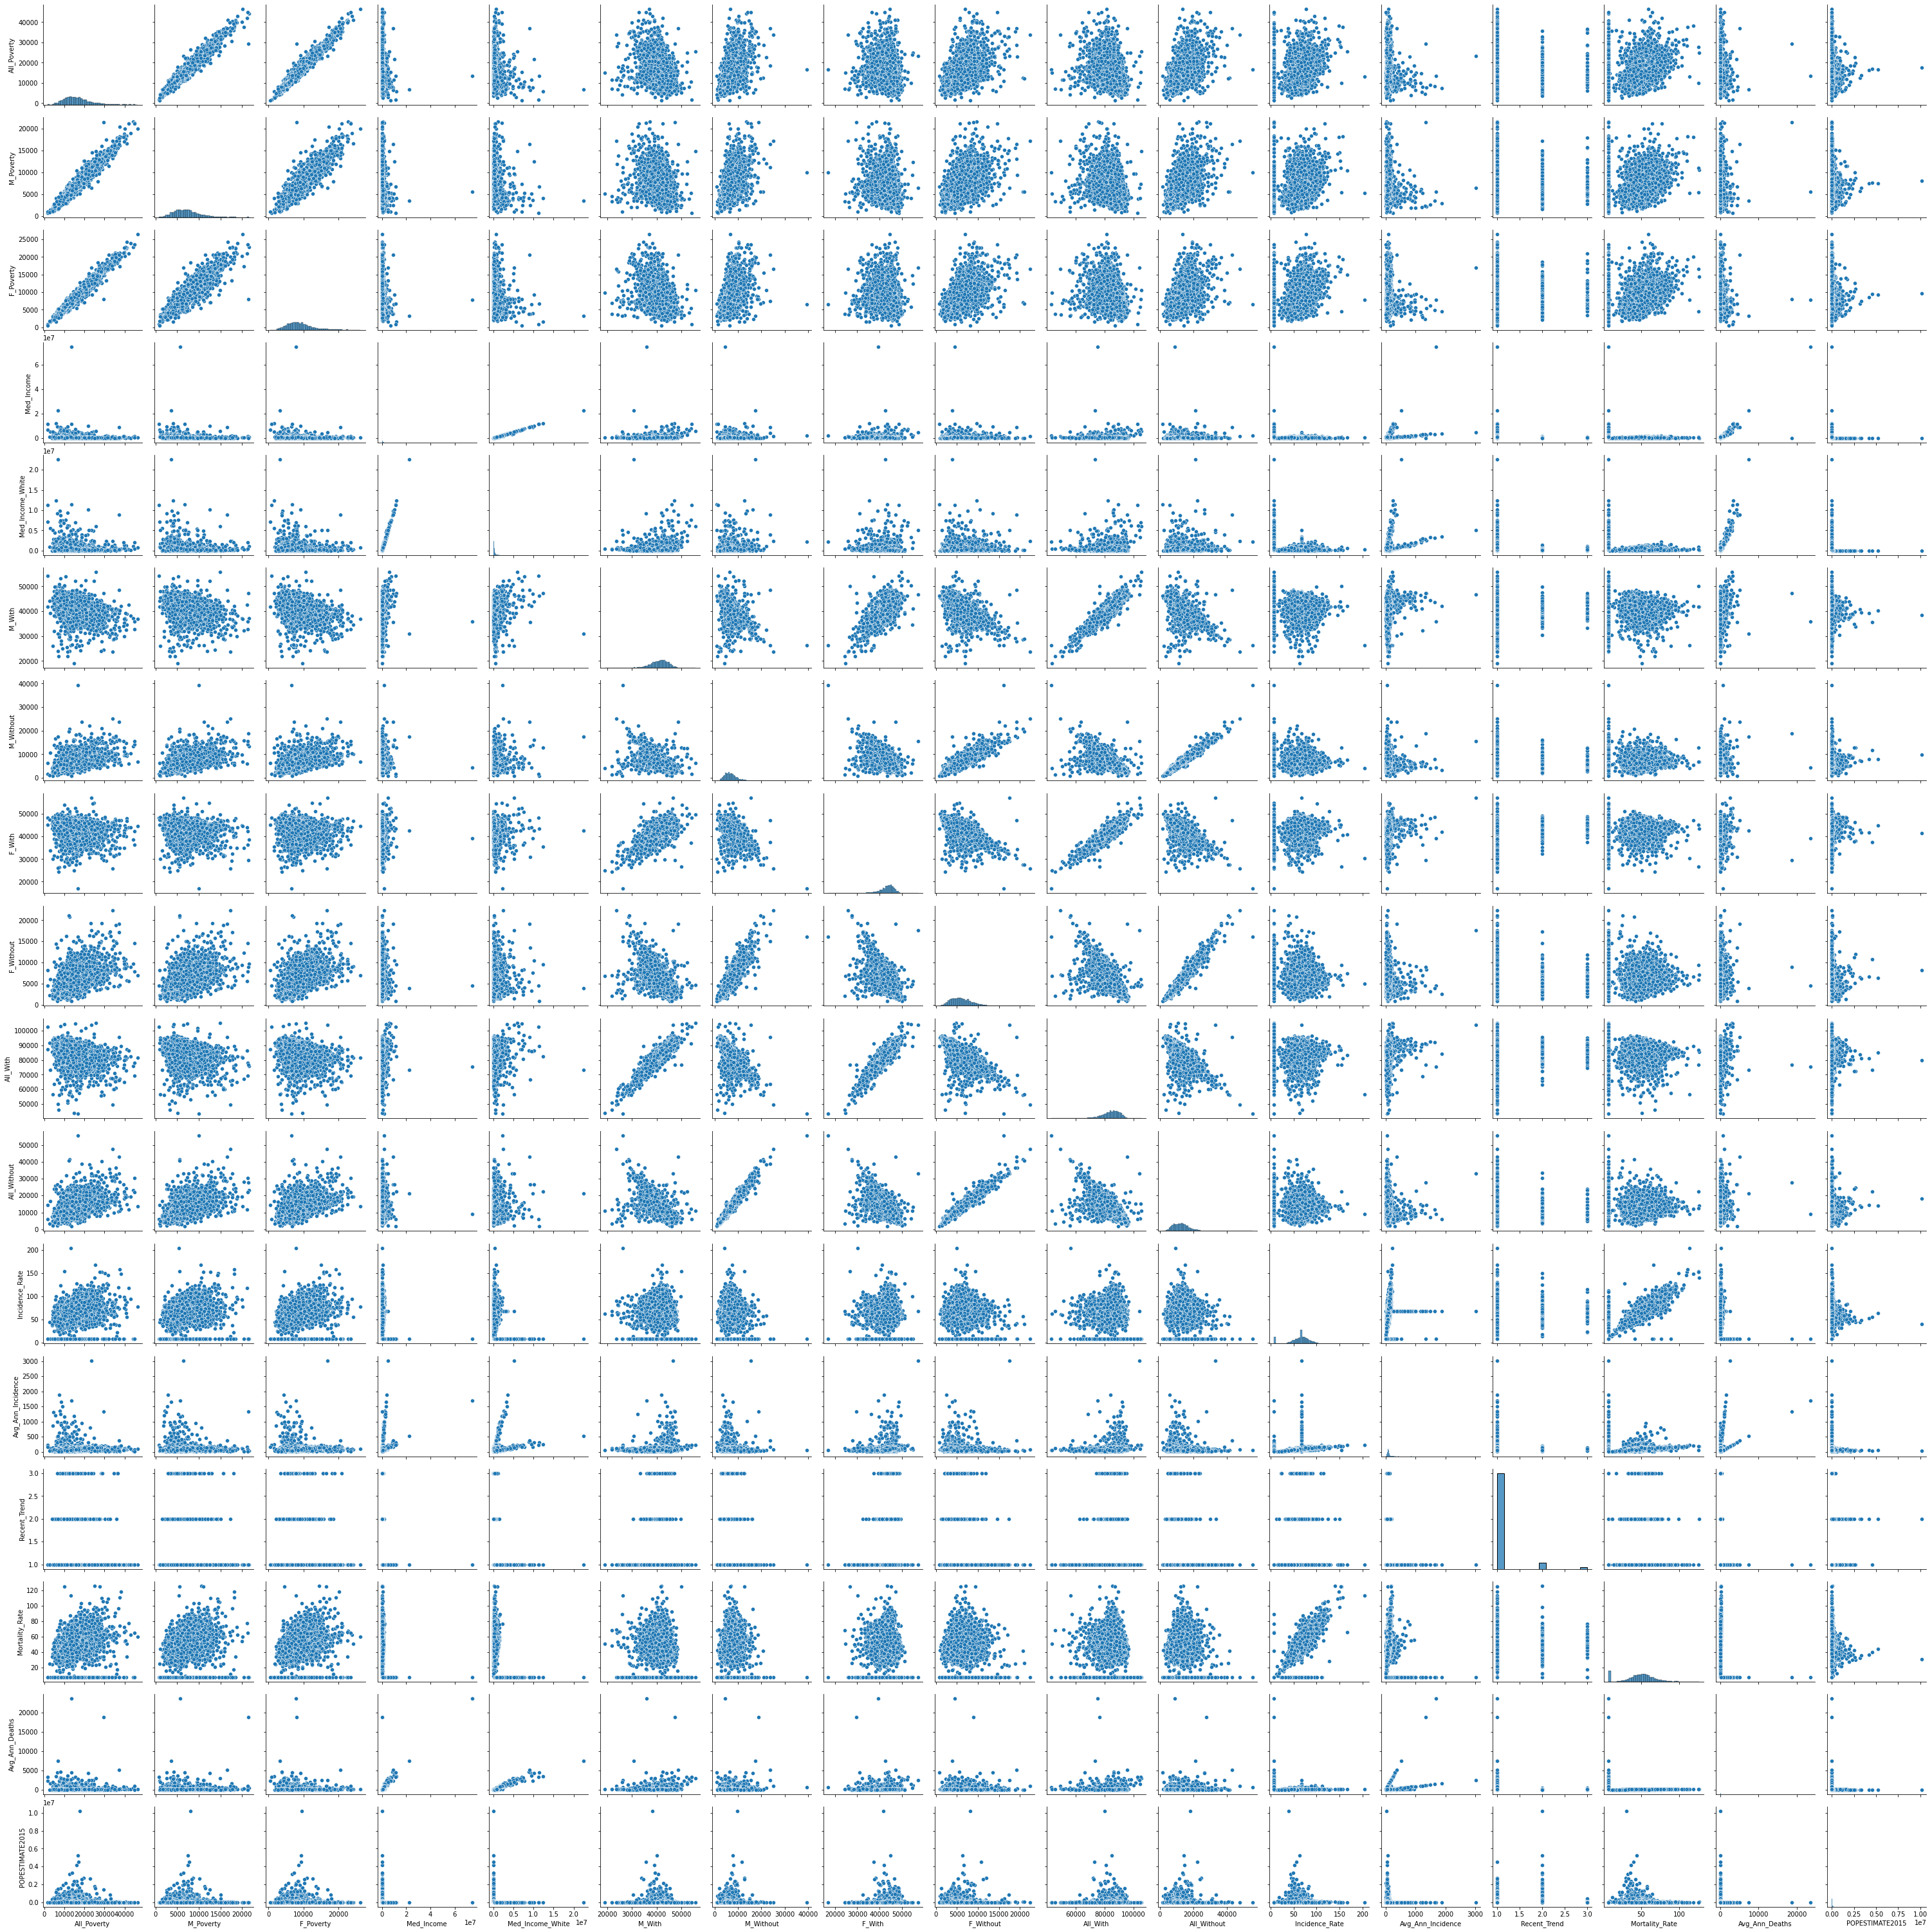

In [74]:
sns.pairplot(fulldf_median)

In [75]:
model_df1 = fulldf_median.drop(["M_Poverty","F_Poverty", "M_With", "M_Without", "F_With", 
                            "F_Without", "Med_Income_White", "State", "AreaName", "FIPS", "POPESTIMATE2015"], axis=1)
round(model_df1.head(),2)

All_Poverty  Med_Income  All_With  All_Without  Incidence_Rate  \
0     16551.93  1841305.00  43160.73     55582.16             8.0   
1      8751.32  1478533.85  73255.00     23377.76             8.0   
2      8006.16    26222.74  81411.81     14944.34            61.5   
3     24317.40   284252.76  72567.70     24974.92            62.7   
4      7735.43  8940582.96  86098.65     21412.56             8.0   

   Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0              44.90           1.0             8.0          628.55  
1              26.31           1.0             8.0          368.29  
2              43.86           1.0            47.3           32.14  
3              33.43           1.0            58.3           27.86  
4             168.16           1.0             8.0         2354.26

### **Regression Model Construction**

In [76]:
# Shuffle the dataset and reset the index
# We are going to do a 3-way split of the data to 60%, 20%, 20% 
# for training, validation, and test datasets respectively
model_df1 = model_df1.sample(frac=1).reset_index(drop=True)
round(model_df1.head(),2)

All_Poverty  Med_Income  All_With  All_Without  Incidence_Rate  \
0     15758.56  1329820.55  80783.03     16835.24             8.0   
1      6188.36   120507.98  87757.42      5816.88            48.4   
2     16456.77    68584.82  83731.90     14016.63            73.6   
3      9108.83    64028.33  84963.99     12193.56            62.8   
4     19513.08   123221.06  78979.32     19724.21            68.9   

   Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0              48.94           1.0             8.0          685.15  
1              48.65           1.0            37.0           36.85  
2              89.62           1.0            58.6           72.32  
3              70.48           1.0            49.2           53.96  
4             105.57           1.0            58.8           89.07

In [77]:
# Separate the last 20% as hold-out data (test data)
model_df_hold_out1=model_df1[int(0.80*len(model_df1)):len(model_df1)]
model_df_hold_out1

All_Poverty     Med_Income      All_With   All_Without  Incidence_Rate  \
2507  10414.864959   13157.223275  90099.962291   8083.916842            67.2   
2508  19404.324481   21091.938837  78951.934151  14301.098320            70.3   
2509  11015.898870  118049.998230  87406.607415   9877.483092            71.0   
2510  19172.438500  183311.440172  75883.687604  12419.393360            79.1   
2511   8740.986291   44918.645500  91245.146465   5653.873584            67.8   
...            ...            ...           ...           ...             ...   
3129  16777.313232    6768.710639  81973.429776  15855.857663            50.9   
3130  31841.461727  125764.776450  84344.576201  17173.441609            62.3   
3131  25947.563408  201959.247649  71273.867199  17825.591337           100.0   
3132  17463.729178  319567.053044  81714.899823  18031.780149            62.3   
3133  32379.115989  191463.957283  86739.839810  12963.512311           105.7   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
2507          79.707903           1.0            46.0       54.192342  
2508          66.806595           1.0            51.7       49.357111  
2509          72.589498           1.0            51.6       53.114266  
2510         107.475519           1.0            72.6       95.533795  
2511          16.508624           1.0            32.3       33.017248  
...                 ...           ...             ...             ...  
3129          50.035489           2.0            37.1       36.241244  
3130          87.666682           1.0            52.9       73.824574  
3131         128.241664           1.0            97.2      121.117127  
3132          84.440009           1.0            43.5       53.734551  
3133         133.491546           1.0            73.2       96.410561  

[627 rows x 9 columns]

In [78]:
# Keep the first 80% as training+validation data
model_df_acc1=model_df1[0:int(0.80*len(model_df1))]
model_df_acc1

All_Poverty    Med_Income      All_With   All_Without  Incidence_Rate  \
0     15758.564437  1.329821e+06  80783.034258  16835.236542             8.0   
1      6188.363283  1.205080e+05  87757.418518   5816.884591            48.4   
2     16456.770907  6.858482e+04  83731.899439  14016.634435            73.6   
3      9108.830202  6.402833e+04  84963.987577  12193.564018            62.8   
4     19513.080197  1.232211e+05  78979.315805  19724.210735            68.9   
...            ...           ...           ...           ...             ...   
2502  20142.583528  5.443605e+05  75047.882528  23579.484997            56.8   
2503  18974.490319  4.358570e+04  87504.354062  11905.542465            70.7   
2504  13482.868099  2.016946e+05  88718.921371  10056.487857            68.2   
2505  20903.424354  9.658608e+04  86996.322666  11232.819550            79.1   
2506  10414.560162  1.276694e+06  88397.371082   9580.384226            67.8   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
0             48.939641           1.0             8.0      685.154976  
1             48.646019           1.0            37.0       36.853045  
2             89.618414           1.0            58.6       72.323633  
3             70.483029           1.0            49.2       53.963569  
4            105.565269           1.0            58.8       89.070696  
...                 ...           ...             ...             ...  
2502          53.202809           1.0            39.5       31.921685  
2503          79.909845           1.0            52.1       58.395656  
2504          94.833629           2.0            61.2       86.587226  
2505          91.281329           1.0            57.1       65.200949  
2506         631.951466           1.0            71.7       75.834176  

[2507 rows x 9 columns]

In [79]:
training_data1 = model_df_acc1.sample(frac=0.75, random_state=25)
training_data1

All_Poverty     Med_Income      All_With   All_Without  Incidence_Rate  \
252   22963.737536  134533.368189  83683.758449  15192.142510            90.3   
2130   6445.553351   31600.581660  92685.050542   4749.192262            72.2   
1884  26306.508496  454616.864380  82285.989099  13770.439243           112.4   
1495  12634.095949   45121.977649  84620.774849  11330.881981            65.0   
1097  20127.157130  317729.336966  88964.577657  11262.488647            86.4   
...            ...            ...           ...           ...             ...   
2206  12844.119100  183226.299007  81932.905196  13589.616922            70.4   
2330  16978.034420  258667.346014  92062.952899   8265.398551            76.6   
1023  12601.754275  314980.753455  89221.934751  10948.444501            67.8   
2280  18975.713333   41962.938266  80950.584354  16887.481136            76.2   
1312  15671.674866  109245.224483  89183.619200   8919.469929            90.4   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
252          130.709191           1.0            71.2      100.832804  
2130          83.094290           1.0            52.4       59.668772  
1884         176.338570           1.0            88.9      144.277012  
1495          56.347389           1.0            47.4       41.176938  
1097         127.157130           1.0            68.4       99.909173  
...                 ...           ...             ...             ...  
2206         134.728522           1.0            43.5       80.837113  
2330         113.224638           1.0            59.7       90.579710  
1023         157.758566           1.0            61.8       88.344797  
2280          75.457130           1.0            57.1       56.154143  
1312          93.072730           1.0            64.2       66.480521  

[1880 rows x 9 columns]

In [80]:
validation_data1 = model_df_acc1.drop(training_data1.index)
validation_data1

All_Poverty    Med_Income      All_With   All_Without  Incidence_Rate  \
4     19513.080197  1.232211e+05  78979.315805  19724.210735            68.9   
5     18801.581028  1.204206e+05  86928.063241  13097.233202            87.8   
10    33673.213539  2.273046e+05  86477.225240  16372.753865            79.2   
11    12924.448217  1.023833e+06  90110.356537  10398.981324            78.4   
14    25864.664012  5.454517e+04  86938.321156  11580.069612            93.6   
...            ...           ...           ...           ...             ...   
2492  11223.418945  3.889699e+05  73631.593482  18514.222590            64.3   
2493  20604.147881  8.453562e+05  79283.137962  18620.378720            64.2   
2496  14618.011097  3.205790e+05  85090.340020  14518.423673            46.9   
2502  20142.583528  5.443605e+05  75047.882528  23579.484997            56.8   
2505  20903.424354  9.658608e+04  86996.322666  11232.819550            79.1   

      Avg_Ann_Incidence  Recent_Trend  Mortality_Rate  Avg_Ann_Deaths  
4            105.565269           1.0            58.8       89.070696  
5            142.292490           1.0            61.1       98.023715  
10           108.650230           1.0            62.8       91.934810  
11           148.556876           1.0            57.6      106.112054  
14           125.427237           1.0            74.7       98.773949  
...                 ...           ...             ...             ...  
2492          49.710025           1.0            47.6       38.663353  
2493          90.171326           1.0            70.0       90.171326  
2496          71.133874           1.0            37.3       56.907099  
2502          53.202809           1.0            39.5       31.921685  
2505          91.281329           1.0            57.1       65.200949  

[627 rows x 9 columns]

In [81]:
formula_median = "Mortality_Rate~" + "+".join(model_df_acc1.columns.drop(["Mortality_Rate"]))
formula_median

'Mortality_Rate~All_Poverty+Med_Income+All_With+All_Without+Incidence_Rate+Avg_Ann_Incidence+Recent_Trend+Avg_Ann_Deaths'

In [82]:
#best yet with VIF
formula_median1 = 'Mortality_Rate ~ (All_Poverty+Med_Income)*(Incidence_Rate+Avg_Ann_Incidence)'


### ***Model Selection***

In [83]:
lm6_median = smf.ols(formula_median1, data = training_data1).fit()
print(lm6_median.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     678.1
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:07:07   Log-Likelihood:                -6941.0
No. Observations:                1880   AIC:                         1.390e+04
Df Residuals:                    1871   BIC:                         1.395e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [84]:
preds_median = lm6_median.predict(model_df_acc1)
square_error_median = (model_df_acc1['Mortality_Rate'] - preds_median)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error_median[validation_data1.index]))

--------Validation MSE for linear regression model--------
MSE: 91.47989299685882


###***Reporting test performance***

In [85]:
preds_hold_out_median = lm6_median.predict(model_df_hold_out1)
square_error_hold_out_median = (model_df_hold_out1['Mortality_Rate'] - preds_hold_out_median)**2
print('--------Test MSE for linear regression model--------')
print('MSE:',np.mean(square_error_hold_out_median))

--------Test MSE for linear regression model--------
MSE: 342.04797897466227


### **APPENDIX 2- Other Models**

In [86]:
formula = "Mortality_Rate~" + "+".join(model_df_acc.columns.drop(["Mortality_Rate"]))
formula

'Mortality_Rate~All_Poverty+Med_Income+All_With+All_Without+Incidence_Rate+Avg_Ann_Incidence+Recent_Trend+Avg_Ann_Deaths'

In [87]:
lm = smf.ols(formula, data = training_data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     457.4
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:07:07   Log-Likelihood:                -5795.1
No. Observations:                1567   AIC:                         1.161e+04
Df Residuals:                    1558   BIC:                         1.166e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.6556      5.15

In [88]:
formula3 = 'Mortality_Rate~All_Poverty+Med_Income+All_With+Incidence_Rate+Avg_Ann_Incidence+Avg_Ann_Deaths'

In [89]:
lm3 = smf.ols(formula3, data = training_data).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     609.8
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:07:07   Log-Likelihood:                -5795.9
No. Observations:                1567   AIC:                         1.161e+04
Df Residuals:                    1560   BIC:                         1.164e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.5423      3.47

In [90]:
formula4 = 'Mortality_Rate~All_Poverty+Med_Income+Avg_Ann_Incidence+Incidence_Rate'

In [91]:
lm4 = smf.ols(formula4, data = training_data).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     908.7
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:07:07   Log-Likelihood:                -5800.2
No. Observations:                1567   AIC:                         1.161e+04
Df Residuals:                    1562   BIC:                         1.164e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.3331      0.96

In [92]:
#best overall (fails at VIF)
formula5 = 'Mortality_Rate~ (All_Poverty+Med_Income+All_With+Avg_Ann_Deaths)*(Incidence_Rate+Avg_Ann_Incidence)'


In [93]:
lm5 = smf.ols(formula5, data = training_data).fit()
print(lm5.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     425.7
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:07:07   Log-Likelihood:                -5506.5
No. Observations:                1567   AIC:                         1.104e+04
Df Residuals:                    1552   BIC:                         1.112e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [94]:
formula2 = "Mortality_Rate~" + "+".join(model_df_acc.columns.drop(["Mortality_Rate",'All_Poverty','All_Without','Recent_Trend']))
formula2

'Mortality_Rate~Med_Income+All_With+Incidence_Rate+Avg_Ann_Incidence+Avg_Ann_Deaths'

In [95]:
lm2 = smf.ols(formula2, data = training_data).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     688.9
Date:                Fri, 10 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:07:08   Log-Likelihood:                -5829.0
No. Observations:                1567   AIC:                         1.167e+04
Df Residuals:                    1561   BIC:                         1.170e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.7425      3.14

In [96]:
preds = lm.predict(model_df_acc)
square_error = (model_df_acc['Mortality_Rate'] - preds)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 86.92038441288311


In [97]:
preds1 = lm2.predict(model_df_acc)
square_error1 = (model_df_acc['Mortality_Rate'] - preds1)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error1[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 88.67845753065767


In [98]:
preds3 = lm3.predict(model_df_acc)
square_error3 = (model_df_acc['Mortality_Rate'] - preds3)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error3[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 86.96437286860275


In [99]:
preds4 = lm4.predict(model_df_acc)
square_error4 = (model_df_acc['Mortality_Rate'] - preds4)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error4[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 87.54691643856812


In [100]:
preds5 = lm5.predict(model_df_acc)
square_error5 = (model_df_acc['Mortality_Rate'] - preds5)**2
print('--------Validation MSE for linear regression model--------')
print('MSE:',np.mean(square_error5[validation_data.index]))

--------Validation MSE for linear regression model--------
MSE: 60.87164420762117
